# Práctica 1

Statistical Learning II

Eddson Sierra

In [322]:
import pandas as pd
import numpy as np
from scipy import linalg as LA
import matplotlib.pyplot as plt
import random
import math
from sklearn.mixture import GaussianMixture as GM

In [16]:
normales = pd.read_excel(r"C:\\Users\\eddso\\OneDrive\\Maestría\\Ciclo 3 - 2021\\Statistical Learning II\\Prácticas\\Práctica 1\\estaturas.xlsx",
             sheet_name = "normales")

valtest = pd.read_excel(r"C:\\Users\\eddso\\OneDrive\\Maestría\\Ciclo 3 - 2021\\Statistical Learning II\\Prácticas\\Práctica 1\\estaturas.xlsx",
             sheet_name = "valtest(normales)")

anomalias= pd.read_excel(r"C:\\Users\\eddso\\OneDrive\\Maestría\\Ciclo 3 - 2021\\Statistical Learning II\\Prácticas\\Práctica 1\\estaturas.xlsx",
             sheet_name = "anomalias")

## Implementación de hard clustering con K-means

In [27]:
normales.head()

,Estatura(metros),Edad(años)
0,1.77,26
1,1.74,31
2,1.72,24
3,1.78,34
4,1.65,32


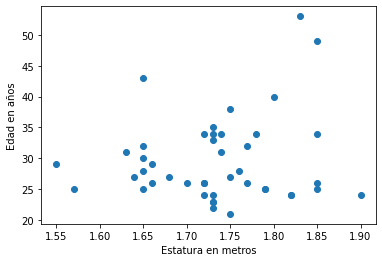

In [34]:
plt.scatter(normales['Estatura(metros)'], normales['Edad(años)'])
plt.xlabel("Estatura en metros")
plt.ylabel("Edad en años")
plt.show()

#### Paso 1: Crear centroides en posiciones aleatorias

In [48]:
# Obtenemos el rango de las dos variables
max_x = normales['Estatura(metros)'].max()
min_x = normales['Estatura(metros)'].min()

max_y = normales['Edad(años)'].max()
min_y = normales['Edad(años)'].min()

print('Rango de estaturas: '+str(min_x)+' - '+str(max_x))
print('Rango de edades: '+str(min_y)+' - '+str(max_y))

Rango de estaturas: 1.55 - 1.9
Rango de edades: 21 - 53


In [110]:
k = 2
centroides = []

# generamos k centroides de manera aleatoria y los guardamos en una lista
for i in range(k): 
    coor_y = random.randrange(min_y, max_y)
    coor_x = round(random.uniform(min_x, max_x),2)
    centroide = coor_x, coor_y
    centroides.append(centroide)
centroides = np.array(centroides)

In [111]:
centroides

array([[ 1.86, 44.  ],
       [ 1.74, 52.  ]])

In [112]:
# Podemos crear una función que inicialice los centroides dado k y los datos
def initialize_centroids(k, data):
    max_x = data.iloc[:,0].max()
    min_x = data.iloc[:,0].min()
    max_y = data.iloc[:,1].max()
    min_y = data.iloc[:,1].min()
    
    centroides = []
    
    for i in range(k): 
        coor_y = random.randrange(min_y, max_y)
        coor_x = round(random.uniform(min_x, max_x),2)
        centroide = coor_x, coor_y
        centroides.append(centroide)
    
    centroides = np.array(centroides)
    return centroides

In [199]:
centroides = initialize_centroids(k = 2, data = normales)
centroides

array([[ 1.86, 32.  ],
       [ 1.7 , 34.  ]])

#### Paso 2: Asignar las observaciones al cluster más cercano
Para este paso debemos crear una función para calcular la distancia de cada observación a cada cluster

In [126]:
# Definimos una fórmula para calcular la distancia entre dos puntos
def distancia(X1, X2):
    return math.sqrt((sum(X1-X2))**2)

In [135]:
# Podemos probar la función con la primera fila de observaciones
distancia(centroides[0], np.array(normales.iloc[1,:]))

5.12

In [186]:
def asignar_centroides(centroides_array, data):
    centroide_asignado = []
    for fila in range(len(data)):
        distancias = []
        for centroide in centroides_array:
            dist = distancia(np.array(data.iloc[fila,:]), centroide)
            distancias.append(dist)
        centroide_asignado.append([np.argmin(distancias), dist])
    clusters = pd.DataFrame(centroide_asignado, columns = ['cluster','distancia_min'])
    
    return pd.concat([data, clusters], axis = 1)

In [188]:
# Comprobamos que la función nos indica el índice del centroide asignado:
asignar_centroides(centroides, normales).head()

,Estatura(metros),Edad(años),cluster,distancia_min
0,1.77,26,0,1.87
1,1.74,31,1,3.10
2,1.72,24,0,3.92
3,1.78,34,1,6.14
4,1.65,32,1,4.01


Debemos calcular la distancia total, ya que esto determina si el algoritmo converge o no:

In [190]:
new_data = asignar_centroides(centroides, normales)
new_data['distancia_min'].sum()

215.43

In [266]:
LA.norm(new_data)

207.01915805065

#### Paso 3: Mover los centroides a la posición promedio de las observaciones de cada cluster

In [234]:
nuevos_centroides = new_data.groupby('cluster').agg('mean').iloc[:,0:2].reset_index(drop = True)
nuevos_centroides 

,Estatura(metros),Edad(años)
0,1.750000,24.500000
1,1.720417,33.833333


#### Paso 4: Unir todo

Ahora podemos unir todos los pasos para crear una función que haga K-means para cierto K y datos

In [377]:
def kmeans(data, k, iteraciones):
    
    # obtener los centroids iniciales
    centroides = initialize_centroids(k, data)
    
    modelos = []
    
    for i in range(iteraciones):
        # asignar observaciones a los clusters
        new_data = asignar_centroides(centroides, data)

        # calcular la distancia total
        distancia = new_data['distancia_min'].sum()
        distorsion = LA.norm(new_data)
        modelos.append((i, centroides, k, distorsion, np.array(new_data['cluster'])))
        
        # calcular los nuenvos centroides
        centroides = np.array(new_data.groupby('cluster').agg('mean').iloc[:,0:2].reset_index(drop = True))
    
    return modelos

In [397]:
modelos = pd.DataFrame(kmeans(normales,3,10), columns = ['iteracion','centroides','k','distorsion','cluster'])

#### Método del codo
Ahora podemos utilizar el método del codo para evaluar si existe un k óptimo:

In [398]:
modelos.head()

,iteracion,centroides,k,distorsion,cluster
0,0,"[[1.62, 40.0], [1.83, 49.0], [1.8, 44.0]]",3,227.889132,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,"[[1.7307317073170727, 28.21951219512195], [1.8...",3,224.799363,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"[[1.728461538461538, 27.666666666666668], [1.8...",3,218.666696,"[0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,"[[1.7231428571428564, 26.914285714285715], [1....",3,212.358347,"[0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,"[[1.723666666666666, 25.9], [1.84, 51.0], [1.7...",3,210.188111,"[0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, ..."


In [410]:
# Podemos obtener la mejor configuración de las iteraciones K y la distorsión
resultado = np.array(modelos.loc[modelos['distorsion'].argmin(),:])
resultado[1:3]

array([array([[ 1.72925926, 25.37037037],
              [ 1.77666667, 48.33333333],
              [ 1.73357143, 33.71428571]]), 3], dtype=object)

Ejecutamos el algoritmo K means varias veces para graficar la distorsión para varios valores de K:

In [392]:
k_dist_arr = np.array([math.inf, math.inf])
for i in range(1,10):
    modelos = pd.DataFrame(kmeans(normales,i,10), columns = ['iteracion','centroides','k','distorsion','cluster'])
    resultado = np.array(modelos.loc[modelos['distorsion'].argmin(),:])
    k_dist = resultado[2:4]
    k_dist_arr = np.vstack((k_dist_arr,k_dist))

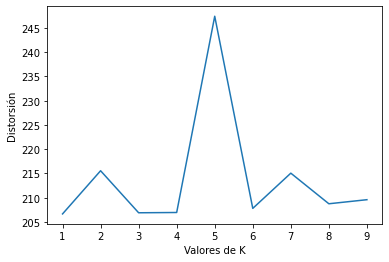

In [393]:
plt.plot(k_dist_arr[:,0],k_dist_arr[:,1])
plt.xlabel('Valores de K')
plt.ylabel('Distorsión')
plt.show()

De acuerdo el método del codo deberíamos elegir el valor de K donde se genera el "codo" en la gráfica de distorsión. Sin embargo, observamos que la gráfica no tiene un codo como tal. Al ver el contenido del arreglo que tiene los valores de K y la distorsión vemos que la menor distorsión (diferente de 1 cluster) se da cuando K = 3.

In [394]:
k_dist_arr

array([[inf, inf],
       [1, 206.6592354522954],
       [2, 215.56153228254803],
       [3, 206.89452913018263],
       [4, 206.95261620853105],
       [5, 247.4208835163273],
       [6, 207.79981857547423],
       [7, 215.06360826508978],
       [8, 208.75337027219464],
       [9, 209.5906913535065]], dtype=object)

In [411]:
# En la posición 4 de resultados obtenemos la asignación de los clusters:
resultado[4]

array([0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2,
       0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 1, 0, 0, 0, 0, 1, 0, 2, 2, 1],
      dtype=int64)

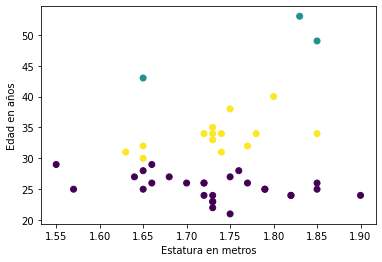

In [412]:
clusters = resultado[4]
plt.scatter(normales.iloc[:,0], normales.iloc[:,1], c = clusters)
plt.xlabel("Estatura en metros")
plt.ylabel("Edad en años")
plt.show()

Si analizamos el centroide de cada cluster podemos observar que la diferencia se produce mayormente debido a la edad y menormente a la estatura. En este caso sería posible **asignar una categoría a cada grupo basada en rangos de edad**. Por elemplo podrían utilizarse los rangos de 25 o menor, 26 a 34 y 35 o mayor. 

In [413]:
resultado[1]

array([[ 1.72925926, 25.37037037],
       [ 1.77666667, 48.33333333],
       [ 1.73357143, 33.71428571]])

## Implementación de soft clustering con GMM

Utilizando el mismo valor de K:

In [352]:
gmm = GM(n_components = 3).fit(normales)
labels = gmm.predict(normales)

In [354]:
labels

array([0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 2, 0, 0, 0, 0, 2, 0, 1, 1, 2],
      dtype=int64)

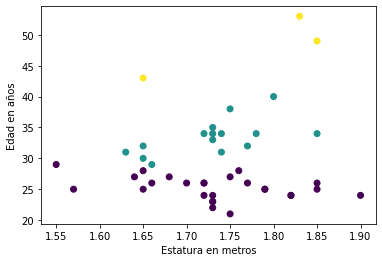

In [355]:
plt.scatter(normales.iloc[:,0], normales.iloc[:,1], c = labels)
plt.xlabel("Estatura en metros")
plt.ylabel("Edad en años")
plt.show()

Con el Gaussian Mixture Model podemos obtener también las probabilidades de que cada observación permanezca a cierto cluster:

In [353]:
probs = gmm.predict_proba(normales)
np.round(probs,3)

array([[0.999, 0.001, 0.   ],
       [0.021, 0.979, 0.   ],
       [1.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   ],
       [0.013, 0.987, 0.   ],
       [0.495, 0.505, 0.   ],
       [0.903, 0.097, 0.   ],
       [0.   , 1.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.985, 0.015, 0.   ],
       [1.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   ],
       [0.99 , 0.01 , 0.   ],
       [0.939, 0.061, 0.   ],
       [0.971, 0.029, 0.   ],
       [0.991, 0.009, 0.   ],
       [0.002, 0.998, 0.   ],
       [0.   , 1.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ],
       [0.873, 0.127, 0.   ],
       [0.953, 0.047, 0.   ],
       [0.941, 0.059, 0.   ],
       [0.215, 0.785, 0.   ],
       [0.995, 0.005, 0.   ],
       [1.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   ],
       [0.

## Estimación usando los datos de la pestaña valtest(normales)

Primero, graficamos las observaciones en un scatter plot:

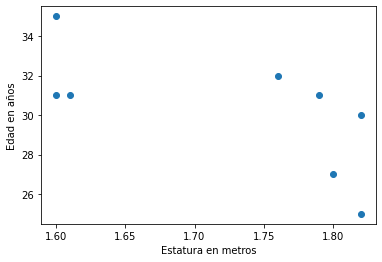

In [415]:
plt.scatter(valtest['Estatura(metros)'], valtest['Edad(años)'])
plt.xlabel("Estatura en metros")
plt.ylabel("Edad en años")
plt.show()

Definimos una función para seleccionar el valor de k y graficar distorsión vs valores de k:

In [418]:
def seleccionar_k(data, max_k):
    k_dist_arr = np.array([math.inf, math.inf])
    for i in range(1,max_k):
        modelos = pd.DataFrame(kmeans(data,i,10), columns = ['iteracion','centroides','k','distorsion','cluster'])
        resultado = np.array(modelos.loc[modelos['distorsion'].argmin(),:])
        k_dist = resultado[2:4]
        k_dist_arr = np.vstack((k_dist_arr,k_dist))
        
    plt.plot(k_dist_arr[:,0],k_dist_arr[:,1])
    plt.xlabel('Valores de K')
    plt.ylabel('Distorsión')
    plt.show()
    
    return k_dist_arr

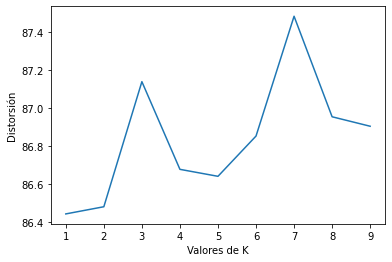

array([[inf, inf],
       [1, 86.44415654050886],
       [2, 86.48186168208915],
       [3, 87.13898094423644],
       [4, 86.67831331999949],
       [5, 86.6417012760022],
       [6, 86.8532670657817],
       [7, 87.4826634253896],
       [8, 86.95448234565025],
       [9, 86.90474900717452]], dtype=object)

In [420]:
seleccionar_k(valtest, 10)

La menor distorsión se encuentra en k = 2. 

Ahora podemos utilizar este valor en la función kmeans para determinar a qué clusters se asigna cada observación:

In [435]:
modelos2 = pd.DataFrame(kmeans(valtest,2,10), columns = ['iteracion','centroides','k','distorsion','cluster'])
resultado2 =  np.array(modelos2.loc[modelos2['distorsion'].argmin(),:])
clusters_asignados_Kmeans = resultado2[4]
clusters_asignados_Kmeans

array([1, 1, 1, 0, 1, 0, 1, 1], dtype=int64)

Determinamos la probabilidad de pertenecer a cada cluster según GMM (y también generamos a que clusters se asignan según GMM): 

In [436]:
gmm2 = GM(n_components = 2).fit(valtest)
clusters_asignados_GMM = gmm2.predict(valtest)
probs_GMM = gmm2.predict_proba(valtest)
np.round(probs_GMM,3)

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

Ahora podemos comparar los resultados en un scatter plot. 

**Asignación de clusters según Kmeans:**

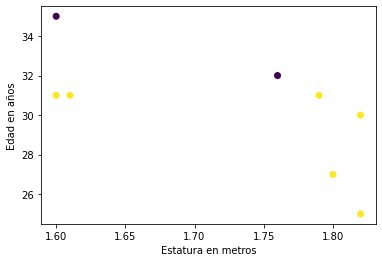

In [440]:
plt.scatter(valtest.iloc[:,0], valtest.iloc[:,1], c = clusters_asignados_Kmeans)
plt.xlabel("Estatura en metros")
plt.ylabel("Edad en años")
plt.show()

**Asignación de clusters según GMM:**

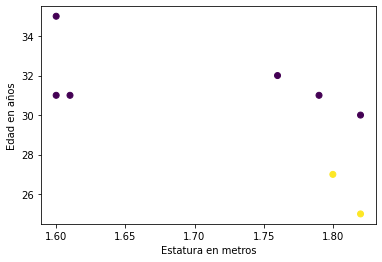

In [441]:
plt.scatter(valtest.iloc[:,0], valtest.iloc[:,1], c = clusters_asignados_GMM)
plt.xlabel("Estatura en metros")
plt.ylabel("Edad en años")
plt.show()

## Usar GMM para estimación de Monte Carlo

Simular 1000 observaciones para hacer una estimación de Monte Carlo del valor esperado de la siguiente función:

$$f(edad,estatura) = \frac{estatura}{edad}$$

In [454]:
def f(X):
    estatura = X[:,0]
    edad = X[:,1]
    return estatura/edad

In [456]:
muestra, cluster = gmm.sample(1000)

muestra_f = f(muestra)
valor_esperado_f = np.mean(muestra_f)

In [457]:
valor_esperado_f

0.060901823524371214

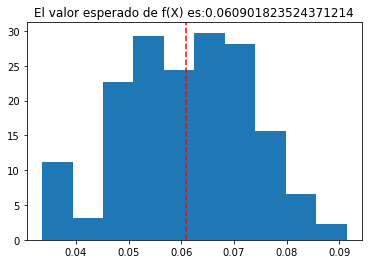

In [463]:
plt.hist(muestra_f, density=True)
plt.axvline(valor_esperado_f,color="r",linestyle="--")
plt.title("El valor esperado de f(X) es:{}".format(valor_esperado_f))
plt.show()

## Conclusión y análisis final

* El resultado de hard clustering con K-means (manual) vs. soft clustering con GMM es prácticamente el mismo (si se usa el mismo valor de K), sin embargo GMM permite obtener las predicciones probabilísticas de cada cluster (para el caso de los datos de la primera pestaña). 


* Cuando se analiza el centroide de cada cluster, para este caso en particular, se puede observar que es posible asignar categorías basadas en rango de edad, ya que los clusters se asignan principalmente por la diferencia de edades y en menor medida por la diferencia de estaturas. 


* El método del codo no siempre produce un "codo" en la gráfica de k-distorsión, por lo que no siempre es conveniente utilizarlo, pero es una buena práctica para observar cual es el valor de K que produce la menor distorsión. 


* Cuando se evaluan los datos "valtest" los resultados de Kmeans difieren de los de GMM. En el caso de GMM, la asignación de los clusters es mejor ya que la separación es más clara. 


* Es posible utilizar el Gaussian Mixture Model para generar muestras y hacer una simulación de Monte Carlo. En Scikit Learn se hace a través del método .sample. 